In [1]:
# -*- coding: utf-8 -*-
"""
Created on  May 1 2018
Modified on Nov 13 2020
"""



import collections


from nltk.corpus import CategorizedPlaintextCorpusReader

import random
from nltk.stem.snowball import SnowballStemmer
import numpy as np
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import Perceptron
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool, cv

from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score


from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import pickle
############################################################################### 
import matplotlib.pyplot as plt


In [2]:
import pandas as pd
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from pprint import pprint
from sklearn.model_selection import train_test_split

from sklearn import metrics   
from sklearn.feature_selection import SelectFromModel,RFECV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, PredefinedSplit
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler


from sklearn import metrics   
from imblearn.over_sampling import SMOTE

pd.options.mode.chained_assignment = None
import re
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
#warnings.filterwarnings('always')
import pickle

from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score
from imblearn.metrics import specificity_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import make_scorer, f1_score, roc_auc_score, precision_score, recall_score, confusion_matrix
from sklearn import metrics   

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

from catboost import CatBoostClassifier, Pool, cv
from sklearn.neural_network import MLPClassifier


In [3]:

wiki_path = 'C:/Revision Frontiers/Wiktionary lexicons/lemmatised/'
datasets_path = 'C:/Revision Frontiers/Data/'


In [4]:
# oversampling with SMOTE with 'minority' and 'not majority'
def over_sample_SMOTE(X_train, y_train):
    sm=SMOTE(sampling_strategy='not majority', random_state=10) # 'minority'
    X_train_ovr, y_train_ovr=sm.fit_sample(X_train, y_train)

    #print(X_train_ovr.shape, y_train_ovr.shape)
    return X_train_ovr, y_train_ovr

In [53]:
def get_evaluation_metrics(reference, result):

    evaluation_metrics = collections.namedtuple('evaluation_metrics', ['accuracy', 'avg_recall','avg_precision','avg_F1']) 
    accuracy = accuracy_score(reference,result)  
    avg_recall = recall_score(reference,result,average='weighted')    
    avg_precision = precision_score(reference,result,average='weighted')    
    avg_F1 = f1_score(reference,result,average='weighted')  
   
    evm = evaluation_metrics(accuracy,avg_recall,avg_precision,avg_F1)
    return evm



In [6]:
def print_results(accu, prec, rec, f1):   
    print('.....................')
    print("Accuracy: %.2f%% " % (accu))
    print("Precision: %.2f%% " % (prec))
    print("Recall: %.2f%% " % (rec))
    print("F1 score: %.2f%% " % (f1))
    print('..................................................')
    print('\n')

In [7]:
def save_results(sheet, criterion, model_name, prec, rec, f1, ind):   
    sheet.write(ind,0,'Criterion' + criterion + '')
    sheet.write(ind+1,0,model_name)
    sheet.write(ind+1,1,round(rec,2))
    sheet.write(ind+1,2,round(prec,2))
    sheet.write(ind+1,3,round(f1,2))
    sheet.write(ind+1,4,'')
    
  

In [8]:

def read_words(words_file):
    with open(words_file, 'r') as f:
        words_list = []
        for word in f:
            words_list.append(word.rstrip())
        return words_list


In [9]:

def select_k_features(X_train,X_test,y_train,k):
    selection = SelectKBest(mutual_info_classif, k)
    X_train = selection.fit_transform(X_train,y_train)
    X_test = selection.transform(X_test)
    
    return X_train, X_test

In [10]:

def normalize_text_wiki(text, criteria, lemmatize = None,remove_stop = None):
    
    import re
    text = re.compile(r'\W+', re.UNICODE).split(text)
    comparitive_forms = read_words(wiki_path + 'comparative_forms.txt')
    modal_adverbs = read_words(wiki_path + 'modal_adverbs.txt')
    act_adverbs = read_words(wiki_path +'act_adverbs.txt')
    manner_adverbs = read_words(wiki_path +'manner_adverbs.txt')
    superlative_forms = read_words(wiki_path +'superlative_forms.txt')
    numerals = read_words(wiki_path + 'numerals.txt')
    degree_adverbs = read_words(wiki_path + 'degree_adverbs.txt')
    auxiliary_verbs = read_words(wiki_path + 'auxiliary_verbs.txt')

    wiki_text = []  
    for word in text:
        if word in comparitive_forms  and (criteria == 2 or criteria ==7):
            wiki_text.append('COMPARITIVE')
        if word in numerals and (criteria == 1 or criteria ==3) :
            wiki_text.append('NUMERAL')
        elif word in degree_adverbs and (criteria == 2 or criteria ==3 or criteria ==4 or criteria ==5 or criteria ==7):
            wiki_text.append('DEGREE_ADVERB')
        elif word in auxiliary_verbs and (criteria == 2 or criteria ==3):
            wiki_text.append('AUXILIARY_VERB')
         #########           
#        elif word in modal_adverbs:
#            wiki_text.append('MODAL')
#        elif word in act_adverbs:
#            wiki_text.append('ACT_ADVERBS')
#        elif word in manner_adverbs:
#            wiki_text.append('MANNER_VERBS')
#        elif word in superlative_forms  and (criteria == 7 ):
#            wiki_text.append('SUPERLATIVE')
                
        
        else:
            wiki_text.append(word)
      
    " ".join([ word for word in wiki_text])      
    return wiki_text                         



In [11]:
pipe = Pipeline([('CV', TfidfVectorizer(ngram_range=(1, 3), max_features  = 7000, lowercase=False, sublinear_tf  =True)), # MinMaxScaler()
                 ('selector', SelectKBest(mutual_info_classif, k=50)), #
                 ('classifier', LogisticRegression())])

search_space = [{'selector__k': [ 50, 200, 500,1000]},
                
                {'classifier': [LogisticRegression(solver='lbfgs')],
                 'classifier__C': [0.01, 0.1, 1.0],
                 'classifier__penalty': ['l1', 'l2', None],
                 'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                 'classifier__max_iter':[100, 150, 200], 
                 'classifier__class_weight':[None, 'balanced']},
                 
                {'classifier': [ SVC()],
                 'classifier__kernel': ['rbf','linear'],
                 'classifier__gamma': [1e-3, 1e-4], 
                 'classifier__C': [1, 10, 100]},
                
                {'classifier': [RandomForestClassifier()],
                 'classifier__max_depth': [5, 10, 30, None],
                 'classifier__criterion':['gini','entropy'], 
                 'classifier__bootstrap': [True],
                 'classifier__max_features':['log2', None],
                 'classifier__n_estimators': [50, 100, 200, 400]},
                
                
                {'classifier': [CatBoostClassifier(random_seed=1)],
                 'classifier__learning_rate': [0.05, 0.1, 0.15, 0.2]},
                
                {'classifier': [XGBClassifier(objective='binary:logistic', random_state=1)],
                 'classifier__learning_rate': [0.05, 0.1, 0.15, 0.2],
                 'classifier__colsample_bytree':[.5, .75, 1],
                 'classifier__max_depth': np.arange(3, 6, 10),
                 'classifier__n_estimators': [50, 100, 200, 400]}]
                  

scorer = make_scorer(f1_score, average = 'binary')

In [16]:
LR_pipe = Pipeline([('CV', TfidfVectorizer(ngram_range=(1, 3), max_features  = 7000, lowercase=False, sublinear_tf  =True)), # MinMaxScaler()
                 ('selector', SelectKBest(mutual_info_classif, k=90)), #
                 ('classifier', LogisticRegression())])

LR_search_space = [{'selector__k': [ 50, 200, 500,1000]},
                
                {'classifier': [LogisticRegression(solver='lbfgs')],
                 'classifier__C': [0.1, 1.0],
                 'classifier__penalty': [ 'l2', None],
                 'classifier__solver': [ 'lbfgs', 'liblinear'], #'newton-cg', 'sag', 'saga'
                 'classifier__max_iter':[100, 200], 
                 'classifier__class_weight':[None, 'balanced']}]
                 
################################################################################          

SVM_pipe = Pipeline([('CV', TfidfVectorizer(ngram_range=(1, 3), max_features  = 7000, lowercase=False, sublinear_tf  =True)), # MinMaxScaler()
                 ('selector', SelectKBest(mutual_info_classif, k=90)), #
                 ('classifier',  SVC())])

SVM_search_space = [{'selector__k': [ 50, 200, 500,1000]},
                
                {'classifier': [ SVC()],
                 'classifier__kernel': ['rbf','linear'],
                 'classifier__C': [1, 8,10]}]
                  
################################################################################

RF_pipe = Pipeline([('CV', TfidfVectorizer(ngram_range=(1, 3), max_features  = 7000, lowercase=False, sublinear_tf  =True)), # MinMaxScaler()
                 ('selector', SelectKBest(mutual_info_classif, k=90)), #
                 ('classifier', RandomForestClassifier())])

RF_search_space = [{'selector__k': [ 50, 200, 500,1000]},
                
                {'classifier': [RandomForestClassifier()],
                 'classifier__max_depth': [5, 10, 30, None],
                 'classifier__criterion':['gini','entropy'], 
                 'classifier__bootstrap': [True],
                 'classifier__max_features':['log2', None],
                 'classifier__n_estimators': [50, 100, 200, 400]}]
                  
################################################################################

CB_pipe = Pipeline([('CV', TfidfVectorizer(ngram_range=(1, 3), max_features  = 7000, lowercase=False, sublinear_tf  =True)), 
                 ('selector', SelectKBest(mutual_info_classif, k=90)), #
                 ('classifier', CatBoostClassifier(random_seed=1))])

CB_search_space = [{'selector__k': [ 50, 200, 500,1000]},
                
                {'classifier': [CatBoostClassifier(random_seed=1, verbose=False)],
                 'classifier__learning_rate': [0.05, 0.1, 0.15]}]

################################################################################

XGB_pipe = Pipeline([('CV', TfidfVectorizer(ngram_range=(1, 3), max_features  = 7000, lowercase=False, sublinear_tf  = True)), 
                 ('selector', SelectKBest(mutual_info_classif, k=90)), #
                 ('classifier', XGBClassifier(objective='binary:logistic', random_state=1))])

XGB_search_space = [{'selector__k': [ 50, 200, 500,1000]},
                
                {'classifier': [XGBClassifier(objective='binary:logistic', random_state=1)],
                 'classifier__learning_rate': [0.05, 0.1, 0.15],
                 'classifier__colsample_bytree':[.5, 1],
                 'classifier__max_depth': np.arange(3, 6, 10),
                 'classifier__n_estimators': [50, 100, 200, 400]}]

In [17]:
def grid_search_wrapper(pipe = pipe, search_space = search_space, verbose= False,refit_score=scorer):
    """
    fits a GridSearchCV classifiers using refit_score for optimization
    prints classifier performance metrics
    """
    cross_validation = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

    grid_search = GridSearchCV(pipe, search_space, cv=cross_validation, verbose=verbose,  n_jobs = -1) #scoring=scorer, refit=scorer
    
    grid_search.fit(X, y)
    
    return grid_search

In [18]:
best_LR = []
best_RF = []
best_SVM = []
best_XGB = []
best_CB = []

In [58]:

###################################################################################        
############################### Start Execution Point #############################        
###################################################################################        
import datetime
print(datetime.datetime.now())

import xlwt

#mydir = 'C:/Users/'+machinename+'/New folder/Dropbox/PhD Brighton/Dataset/healthnewsreview_org/Classified News/Training'
#mydir = 'C:/Users/'+machinename+'/New folder/Dropbox/PhD Brighton/Dataset/healthnewsreview_org/NA is ignored/Classified Story/Criteria 3'

import xlsxwriter


# Create an new Excel file and add a worksheet.
#workbook = xlsxwriter.Workbook('C:/Users/majed.aljefri/Dropbox/PhD Brighton/Writing/Automatic Identification of Information Quality Metrics in Health News Stories/Revision Frontiers/Data/')

#sheet = workbook.add_worksheet('resu')
workbook = xlwt.Workbook()
sheet = workbook.add_sheet('resu')

#import xlwt
#
#book = xlwt.Workbook()
#sheet = book.add_sheet('Cross val results')


2020-11-16 17:15:06.331880


In [31]:

j=0
for i in range(10):
    
    dataset = str(i+1)

    preprocessed = datasets_path + '/Criteria '+dataset+'/data_unix.pkl' 
   

    print('Training, Criteria ' + dataset + ' :' )
    
    
  # Getting back the objects:
    with open(preprocessed, 'rb') as f:  # Python 3: open(..., 'rb')
        train_data, train_labels, test_data,test_labels,test_fileIds = pickle.load(f)
    
    train_data = [' '.join(normalize_text_wiki(document, criteria = i+1)) for document in train_data]
    
    
 
       
    X = np.array(train_data)
    y = np.array(train_labels)
    
    ##################################
    
    print("-------------------------------------------------------")
    pipeline_grid_search_LR = grid_search_wrapper(pipe = LR_pipe, search_space = LR_search_space, verbose=2)
    print(pipeline_grid_search_LR.best_estimator_)
    print(pipeline_grid_search_LR.best_score_)
    best_LR.append(pipeline_grid_search_LR.best_estimator_)
    
    print("-------------------------------------------------------")
    pipeline_grid_search_SVM = grid_search_wrapper(pipe = SVM_pipe, search_space = SVM_search_space, verbose=2)
    print(pipeline_grid_search_SVM.best_estimator_)
    print(pipeline_grid_search_SVM.best_score_)
    best_SVM.append(pipeline_grid_search_SVM.best_estimator_)
    
    print("-------------------------------------------------------")
    pipeline_grid_search_RF = grid_search_wrapper(pipe = RF_pipe, search_space = RF_search_space, verbose=2)
    print(pipeline_grid_search_RF.best_estimator_)
    print(pipeline_grid_search_RF.best_score_)
    best_RF.append(pipeline_grid_search_RF.best_estimator_)
    
 
    print("-------------------------------------------------------")
    pipeline_grid_search_XGB = grid_search_wrapper(pipe = XGB_pipe, search_space = XGB_search_space, verbose=2)
    print(pipeline_grid_search_XGB.best_estimator_)
    print(pipeline_grid_search_XGB.best_score_)
    best_XGB.append(pipeline_grid_search_XGB.best_estimator_)
    
    print("-------------------------------------------------------")
    pipeline_grid_search_CB = grid_search_wrapper(pipe = CB_pipe, search_space = CB_search_space, verbose=False)
    print(pipeline_grid_search_CB.best_estimator_)
    print(pipeline_grid_search_CB.best_score_)
    best_CB.append(pipeline_grid_search_CB.best_estimator_)
    print("-------------------------------------------------------")
    
    

Training, Criteria 10 :
-------------------------------------------------------
Learning rate set to 0.010592
0:	learn: 0.6796026	total: 17.2ms	remaining: 17.2s
1:	learn: 0.6652881	total: 30.1ms	remaining: 15s
2:	learn: 0.6518492	total: 43.3ms	remaining: 14.4s
3:	learn: 0.6377995	total: 56.5ms	remaining: 14.1s
4:	learn: 0.6243648	total: 69ms	remaining: 13.7s
5:	learn: 0.6115092	total: 81.4ms	remaining: 13.5s
6:	learn: 0.5994818	total: 94ms	remaining: 13.3s
7:	learn: 0.5880675	total: 106ms	remaining: 13.2s
8:	learn: 0.5756238	total: 119ms	remaining: 13.1s
9:	learn: 0.5633458	total: 131ms	remaining: 13s
10:	learn: 0.5521565	total: 144ms	remaining: 12.9s
11:	learn: 0.5415783	total: 156ms	remaining: 12.8s
12:	learn: 0.5310357	total: 168ms	remaining: 12.8s
13:	learn: 0.5216056	total: 181ms	remaining: 12.7s
14:	learn: 0.5119281	total: 193ms	remaining: 12.7s
15:	learn: 0.5025325	total: 208ms	remaining: 12.8s
16:	learn: 0.4933121	total: 222ms	remaining: 12.8s
17:	learn: 0.4830437	total: 236ms	

In [32]:
best_models = {} # dictionary of best models with best parameters

best_models['Logistic Regression'] = best_LR
best_models['RandomForest Classifier'] = best_RF
best_models['SVM Classifier'] = best_SVM
best_models['XGBoost Classifier'] = best_XGB
best_models['CatBoost Classifier'] = best_CB

In [33]:
#save the best models
np.save('Indiv_best_models.npy', best_models)

In [ ]:
#################################################################
# Load the best models
best_models = np.load('Indiv_best_models.npy',allow_pickle='TRUE').item()

In [59]:
# this is to get all the detailed performance meterics after selecting the best model parameters
k_i = -1
ind = 1
for model_name, model in best_models.items(): 
    
    model_index = -1
    print(model_name)
    for i in range(10):
        model_index = model_index + 1
        model__ = model[model_index]
        clf = model__['classifier']
        if model_name == 'CatBoost Classifier':
            clf = CatBoostClassifier(random_seed=1, verbose=False,learning_rate= 0.1)
            
        #get number of features
        try:
            k = int(str(model__['selector'])[14:17])
        except:
            k = int(str(model__['selector'])[14:16])
           
        #################################
        dataset = str(i+1)

        preprocessed = datasets_path + '/Criteria '+dataset+'/data_unix.pkl' 


        print('Getting training performance Criteria ' + dataset + ' :' )


      # Getting back the objects:
        with open(preprocessed, 'rb') as f:  # Python 3: open(..., 'rb')
            train_data, train_labels, test_data,test_labels,test_fileIds = pickle.load(f)

        train_data = [' '.join(normalize_text_wiki(document, criteria = i+1)) for document in train_data]
        test_data = [' '.join(normalize_text_wiki(document, criteria = i+1)) for document in test_data]
        
        # TFIDF
        cv1 = TfidfVectorizer(ngram_range=(1, 3), max_features  = 7000, lowercase=False, sublinear_tf  =True)
        
        X_train = np.array(train_data)
        y_train = np.array(train_labels)

        X_test = np.array(test_data)
        y_test = np.array(test_labels)

        X_train = cv1.fit_transform(X_train) 
        X_test = cv1.transform(X_test)
        
        # Select best n features
        X_train, X_test = select_k_features(X_train,X_test,y_train,k)
        
        # SOMTE
        #X_train, y_train = over_sample_SMOTE(X_train, y_train)
        
        clf.fit(X_train, y_train)
        
        # test model, measure class label and probability score
        y_pred = clf.predict(X_test)

        #calculate metrices
        
        score =  get_evaluation_metrics(y_test, y_pred)  
        
        accuracy = score.accuracy * 100.0
        precision=score.avg_precision * 100.0
        recall=score.avg_recall * 100.0
        f1=score.avg_F1 * 100.0
        
        print('Restuls for: ', model_name)
        print_results(accuracy, precision, recall, f1)
        save_results(sheet, dataset, model_name, precision, recall, f1, ind)
        
        ind = ind + 2
    
    ind = ind + 1
    
workbook.save('C:/Revision Frontiers/resutls2.xls')

Logistic Regression
Getting training performance Criteria 1 :


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Restuls for:  Logistic Regression
.....................
Accuracy: 76.69% 
Precision: 58.82% 
Recall: 76.69% 
F1 score: 66.57% 
..................................................


Getting training performance Criteria 2 :


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Restuls for:  Logistic Regression
.....................
Accuracy: 66.92% 
Precision: 44.78% 
Recall: 66.92% 
F1 score: 53.65% 
..................................................


Getting training performance Criteria 3 :


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Restuls for:  Logistic Regression
.....................
Accuracy: 64.66% 
Precision: 41.81% 
Recall: 64.66% 
F1 score: 50.78% 
..................................................


Getting training performance Criteria 4 :


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Restuls for:  Logistic Regression
.....................
Accuracy: 60.90% 
Precision: 37.09% 
Recall: 60.90% 
F1 score: 46.10% 
..................................................


Getting training performance Criteria 5 :


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Restuls for:  Logistic Regression
.....................
Accuracy: 83.46% 
Precision: 69.65% 
Recall: 83.46% 
F1 score: 75.93% 
..................................................


Getting training performance Criteria 6 :
Restuls for:  Logistic Regression
.....................
Accuracy: 66.92% 
Precision: 69.62% 
Recall: 66.92% 
F1 score: 64.82% 
..................................................


Getting training performance Criteria 7 :


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Restuls for:  Logistic Regression
.....................
Accuracy: 56.06% 
Precision: 31.43% 
Recall: 56.06% 
F1 score: 40.28% 
..................................................


Getting training performance Criteria 8 :


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Restuls for:  Logistic Regression
.....................
Accuracy: 64.66% 
Precision: 41.81% 
Recall: 64.66% 
F1 score: 50.78% 
..................................................


Getting training performance Criteria 9 :
Restuls for:  Logistic Regression
.....................
Accuracy: 71.97% 
Precision: 79.89% 
Recall: 71.97% 
F1 score: 60.98% 
..................................................


Getting training performance Criteria 10 :


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Restuls for:  Logistic Regression
.....................
Accuracy: 95.45% 
Precision: 91.12% 
Recall: 95.45% 
F1 score: 93.23% 
..................................................


RandomForest Classifier
Getting training performance Criteria 1 :
Restuls for:  RandomForest Classifier
.....................
Accuracy: 77.44% 
Precision: 82.57% 
Recall: 77.44% 
F1 score: 68.32% 
..................................................


Getting training performance Criteria 2 :
Restuls for:  RandomForest Classifier
.....................
Accuracy: 70.68% 
Precision: 69.29% 
Recall: 70.68% 
F1 score: 66.12% 
..................................................


Getting training performance Criteria 3 :
Restuls for:  RandomForest Classifier
.....................
Accuracy: 69.17% 
Precision: 69.80% 
Recall: 69.17% 
F1 score: 63.32% 
..................................................


Getting training performance Criteria 4 :
Restuls for:  RandomForest Classifier
.....................
Accuracy: 69.92%

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Restuls for:  RandomForest Classifier
.....................
Accuracy: 83.46% 
Precision: 69.65% 
Recall: 83.46% 
F1 score: 75.93% 
..................................................


Getting training performance Criteria 6 :
Restuls for:  RandomForest Classifier
.....................
Accuracy: 69.17% 
Precision: 69.24% 
Recall: 69.17% 
F1 score: 68.89% 
..................................................


Getting training performance Criteria 7 :
Restuls for:  RandomForest Classifier
.....................
Accuracy: 50.76% 
Precision: 49.26% 
Recall: 50.76% 
F1 score: 49.37% 
..................................................


Getting training performance Criteria 8 :
Restuls for:  RandomForest Classifier
.....................
Accuracy: 60.90% 
Precision: 56.15% 
Recall: 60.90% 
F1 score: 56.59% 
..................................................


Getting training performance Criteria 9 :
Restuls for:  RandomForest Classifier
.....................
Accuracy: 71.21% 
Precision: 65.34% 

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Restuls for:  RandomForest Classifier
.....................
Accuracy: 95.45% 
Precision: 91.12% 
Recall: 95.45% 
F1 score: 93.23% 
..................................................


SVM Classifier
Getting training performance Criteria 1 :
Restuls for:  SVM Classifier
.....................
Accuracy: 78.95% 
Precision: 79.16% 
Recall: 78.95% 
F1 score: 72.53% 
..................................................


Getting training performance Criteria 2 :
Restuls for:  SVM Classifier
.....................
Accuracy: 69.92% 
Precision: 68.50% 
Recall: 69.92% 
F1 score: 64.32% 
..................................................


Getting training performance Criteria 3 :
Restuls for:  SVM Classifier
.....................
Accuracy: 78.20% 
Precision: 78.49% 
Recall: 78.20% 
F1 score: 76.77% 
..................................................


Getting training performance Criteria 4 :
Restuls for:  SVM Classifier
.....................
Accuracy: 64.66% 
Precision: 63.30% 
Recall: 64.66% 
F1 s

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Restuls for:  SVM Classifier
.....................
Accuracy: 83.46% 
Precision: 69.65% 
Recall: 83.46% 
F1 score: 75.93% 
..................................................


Getting training performance Criteria 6 :
Restuls for:  SVM Classifier
.....................
Accuracy: 72.18% 
Precision: 72.95% 
Recall: 72.18% 
F1 score: 71.60% 
..................................................


Getting training performance Criteria 7 :
Restuls for:  SVM Classifier
.....................
Accuracy: 55.30% 
Precision: 55.06% 
Recall: 55.30% 
F1 score: 55.15% 
..................................................


Getting training performance Criteria 8 :
Restuls for:  SVM Classifier
.....................
Accuracy: 64.66% 
Precision: 61.78% 
Recall: 64.66% 
F1 score: 61.50% 
..................................................


Getting training performance Criteria 9 :
Restuls for:  SVM Classifier
.....................
Accuracy: 70.45% 
Precision: 50.56% 
Recall: 70.45% 
F1 score: 58.87% 
..........

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Restuls for:  SVM Classifier
.....................
Accuracy: 95.45% 
Precision: 91.12% 
Recall: 95.45% 
F1 score: 93.23% 
..................................................


XGBoost Classifier
Getting training performance Criteria 1 :
Restuls for:  XGBoost Classifier
.....................
Accuracy: 75.94% 
Precision: 70.35% 
Recall: 75.94% 
F1 score: 70.49% 
..................................................


Getting training performance Criteria 2 :
Restuls for:  XGBoost Classifier
.....................
Accuracy: 68.42% 
Precision: 65.81% 
Recall: 68.42% 
F1 score: 65.37% 
..................................................


Getting training performance Criteria 3 :
Restuls for:  XGBoost Classifier
.....................
Accuracy: 64.66% 
Precision: 62.24% 
Recall: 64.66% 
F1 score: 62.35% 
..................................................


Getting training performance Criteria 4 :
Restuls for:  XGBoost Classifier
.....................
Accuracy: 65.41% 
Precision: 64.22% 
Recall: 6

In [60]:
# Testing 

workbook2 = xlwt.Workbook()
sheet2 = workbook2.add_sheet('result')


ind = 1
for model_name, model in best_models.items(): 
    
    model_index = -1
    print(model_name)
    for i in range(10):
        model_index = model_index + 1
        model__ = model[model_index]
        clf = model__['classifier']
        if model_name == 'CatBoost Classifier':
            clf = CatBoostClassifier(random_seed=1, verbose=False,learning_rate= 0.1)
            
        #get number of features
        try:
            k = int(str(model__['selector'])[14:17])
        except:
            k = int(str(model__['selector'])[14:16])
            
        #################################
       
        dataset = str(i+1)

        preprocessed = datasets_path + '/Criteria '+dataset+'/data_unix_2.pkl' 


        print('Getting training performance Criteria ' + dataset + ' :' )


      # Getting back the objects:
        with open(preprocessed, 'rb') as f:  # Python 3: open(..., 'rb')
            train_data, train_labels, test_data,test_labels,test_fileIds = pickle.load(f)

        train_data = [' '.join(normalize_text_wiki(document, criteria = i+1)) for document in train_data]
        test_data = [' '.join(normalize_text_wiki(document, criteria = i+1)) for document in test_data]
        
        # TFIDF
        cv1 = TfidfVectorizer(ngram_range=(1, 3), max_features  = 7000, lowercase=False, sublinear_tf  =True)
        
        X_train = np.array(train_data)
        y_train = np.array(train_labels)

        X_test = np.array(test_data)
        y_test = np.array(test_labels)

        X_train = cv1.fit_transform(X_train) 
        X_test = cv1.transform(X_test)
        
        # Select best n features
        X_train, X_test = select_k_features(X_train,X_test,y_train,k)
        
        #train model on imbalance data 
        
        clf.fit(X_train, y_train)
        
        # test model, measure class label and probability score
        y_pred = clf.predict(X_test)

        #calculate metrices
        
        score =  get_evaluation_metrics(y_test, y_pred)  
        
        accuracy = score.accuracy * 100.0
        precision=score.avg_precision * 100.0
        recall=score.avg_recall * 100.0
        f1=score.avg_F1 * 100.0
        
        print('Restuls for: ', model_name)
        print_results(accuracy, precision, recall, f1)
        save_results(sheet2, dataset, model_name, precision, recall, f1, ind)
        
        ind = ind + 2
    
    ind = ind + 1
    
workbook2.save('C:/Revision Frontiers/resutls_test2.xls')

Logistic Regression
Getting training performance Criteria 1 :


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Restuls for:  Logistic Regression
.....................
Accuracy: 76.30% 
Precision: 58.21% 
Recall: 76.30% 
F1 score: 66.04% 
..................................................


Getting training performance Criteria 2 :


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Restuls for:  Logistic Regression
.....................
Accuracy: 67.16% 
Precision: 45.11% 
Recall: 67.16% 
F1 score: 53.97% 
..................................................


Getting training performance Criteria 3 :


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Restuls for:  Logistic Regression
.....................
Accuracy: 64.93% 
Precision: 42.15% 
Recall: 64.93% 
F1 score: 51.12% 
..................................................


Getting training performance Criteria 4 :


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Restuls for:  Logistic Regression
.....................
Accuracy: 60.74% 
Precision: 36.89% 
Recall: 60.74% 
F1 score: 45.91% 
..................................................


Getting training performance Criteria 5 :


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Restuls for:  Logistic Regression
.....................
Accuracy: 82.96% 
Precision: 68.83% 
Recall: 82.96% 
F1 score: 75.24% 
..................................................


Getting training performance Criteria 6 :
Restuls for:  Logistic Regression
.....................
Accuracy: 71.85% 
Precision: 73.04% 
Recall: 71.85% 
F1 score: 71.07% 
..................................................


Getting training performance Criteria 7 :


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Restuls for:  Logistic Regression
.....................
Accuracy: 55.88% 
Precision: 31.23% 
Recall: 55.88% 
F1 score: 40.07% 
..................................................


Getting training performance Criteria 8 :


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Restuls for:  Logistic Regression
.....................
Accuracy: 65.41% 
Precision: 42.79% 
Recall: 65.41% 
F1 score: 51.74% 
..................................................


Getting training performance Criteria 9 :
Restuls for:  Logistic Regression
.....................
Accuracy: 71.32% 
Precision: 79.61% 
Recall: 71.32% 
F1 score: 60.11% 
..................................................


Getting training performance Criteria 10 :


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Restuls for:  Logistic Regression
.....................
Accuracy: 94.12% 
Precision: 88.58% 
Recall: 94.12% 
F1 score: 91.27% 
..................................................


RandomForest Classifier
Getting training performance Criteria 1 :
Restuls for:  RandomForest Classifier
.....................
Accuracy: 77.78% 
Precision: 82.79% 
Recall: 77.78% 
F1 score: 69.39% 
..................................................


Getting training performance Criteria 2 :
Restuls for:  RandomForest Classifier
.....................
Accuracy: 68.66% 
Precision: 65.95% 
Recall: 68.66% 
F1 score: 62.07% 
..................................................


Getting training performance Criteria 3 :
Restuls for:  RandomForest Classifier
.....................
Accuracy: 65.67% 
Precision: 62.60% 
Recall: 65.67% 
F1 score: 57.10% 
..................................................


Getting training performance Criteria 4 :
Restuls for:  RandomForest Classifier
.....................
Accuracy: 68.89%

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Restuls for:  RandomForest Classifier
.....................
Accuracy: 82.96% 
Precision: 68.83% 
Recall: 82.96% 
F1 score: 75.24% 
..................................................


Getting training performance Criteria 6 :
Restuls for:  RandomForest Classifier
.....................
Accuracy: 77.04% 
Precision: 77.02% 
Recall: 77.04% 
F1 score: 77.02% 
..................................................


Getting training performance Criteria 7 :
Restuls for:  RandomForest Classifier
.....................
Accuracy: 58.82% 
Precision: 58.07% 
Recall: 58.82% 
F1 score: 56.14% 
..................................................


Getting training performance Criteria 8 :
Restuls for:  RandomForest Classifier
.....................
Accuracy: 63.91% 
Precision: 59.17% 
Recall: 63.91% 
F1 score: 58.52% 
..................................................


Getting training performance Criteria 9 :
Restuls for:  RandomForest Classifier
.....................
Accuracy: 71.32% 
Precision: 79.61% 

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Restuls for:  RandomForest Classifier
.....................
Accuracy: 94.12% 
Precision: 88.58% 
Recall: 94.12% 
F1 score: 91.27% 
..................................................


SVM Classifier
Getting training performance Criteria 1 :
Restuls for:  SVM Classifier
.....................
Accuracy: 79.26% 
Precision: 83.69% 
Recall: 79.26% 
F1 score: 72.43% 
..................................................


Getting training performance Criteria 2 :
Restuls for:  SVM Classifier
.....................
Accuracy: 70.15% 
Precision: 68.68% 
Recall: 70.15% 
F1 score: 64.56% 
..................................................


Getting training performance Criteria 3 :
Restuls for:  SVM Classifier
.....................
Accuracy: 64.93% 
Precision: 62.49% 
Recall: 64.93% 
F1 score: 62.61% 
..................................................


Getting training performance Criteria 4 :
Restuls for:  SVM Classifier
.....................
Accuracy: 67.41% 
Precision: 66.67% 
Recall: 67.41% 
F1 s

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Restuls for:  SVM Classifier
.....................
Accuracy: 82.96% 
Precision: 68.83% 
Recall: 82.96% 
F1 score: 75.24% 
..................................................


Getting training performance Criteria 6 :
Restuls for:  SVM Classifier
.....................
Accuracy: 73.33% 
Precision: 73.33% 
Recall: 73.33% 
F1 score: 73.33% 
..................................................


Getting training performance Criteria 7 :
Restuls for:  SVM Classifier
.....................
Accuracy: 64.71% 
Precision: 64.45% 
Recall: 64.71% 
F1 score: 63.86% 
..................................................


Getting training performance Criteria 8 :
Restuls for:  SVM Classifier
.....................
Accuracy: 68.42% 
Precision: 66.48% 
Recall: 68.42% 
F1 score: 64.25% 
..................................................


Getting training performance Criteria 9 :
Restuls for:  SVM Classifier
.....................
Accuracy: 71.32% 
Precision: 70.03% 
Recall: 71.32% 
F1 score: 61.30% 
..........

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Restuls for:  SVM Classifier
.....................
Accuracy: 94.12% 
Precision: 88.58% 
Recall: 94.12% 
F1 score: 91.27% 
..................................................


XGBoost Classifier
Getting training performance Criteria 1 :
Restuls for:  XGBoost Classifier
.....................
Accuracy: 76.30% 
Precision: 73.15% 
Recall: 76.30% 
F1 score: 73.73% 
..................................................


Getting training performance Criteria 2 :
Restuls for:  XGBoost Classifier
.....................
Accuracy: 70.15% 
Precision: 68.12% 
Recall: 70.15% 
F1 score: 65.77% 
..................................................


Getting training performance Criteria 3 :
Restuls for:  XGBoost Classifier
.....................
Accuracy: 67.16% 
Precision: 65.25% 
Recall: 67.16% 
F1 score: 65.18% 
..................................................


Getting training performance Criteria 4 :
Restuls for:  XGBoost Classifier
.....................
Accuracy: 70.37% 
Precision: 70.05% 
Recall: 7

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Restuls for:  XGBoost Classifier
.....................
Accuracy: 94.12% 
Precision: 88.58% 
Recall: 94.12% 
F1 score: 91.27% 
..................................................


CatBoost Classifier
Getting training performance Criteria 1 :
Restuls for:  CatBoost Classifier
.....................
Accuracy: 83.70% 
Precision: 82.99% 
Recall: 83.70% 
F1 score: 81.94% 
..................................................


Getting training performance Criteria 2 :
Restuls for:  CatBoost Classifier
.....................
Accuracy: 70.15% 
Precision: 67.98% 
Recall: 70.15% 
F1 score: 66.80% 
..................................................


Getting training performance Criteria 3 :
Restuls for:  CatBoost Classifier
.....................
Accuracy: 69.40% 
Precision: 68.36% 
Recall: 69.40% 
F1 score: 65.29% 
..................................................


Getting training performance Criteria 4 :
Restuls for:  CatBoost Classifier
.....................
Accuracy: 68.15% 
Precision: 67.42% 


Getting top features for Criteria 1 :
Criteria 1
Getting top features for Criteria 2 :
Criteria 2
Getting top features for Criteria 3 :
Criteria 3
Getting top features for Criteria 4 :
Criteria 4
Getting top features for Criteria 5 :
Criteria 5
Getting top features for Criteria 6 :
Criteria 6
Getting top features for Criteria 7 :
Criteria 7
Getting top features for Criteria 8 :
Criteria 8
Getting top features for Criteria 9 :
Criteria 9
Getting top features for Criteria 10 :
Criteria 10


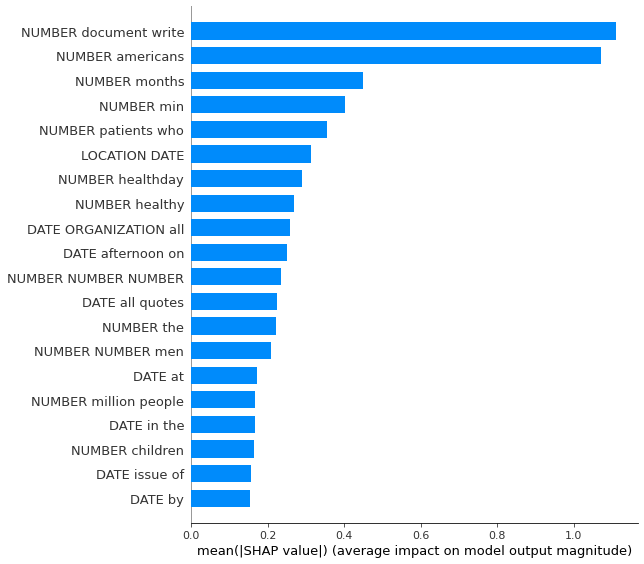

In [61]:
import shap
import matplotlib.pyplot as plt

for model_name, model in best_models.items(): 
    
    model_index = -1
    for i in range(10):
        model_index = model_index + 1
        model__ = model[model_index]
        clf = model__['classifier']
        if model_name == 'CatBoost Classifier':
            clf = CatBoostClassifier(random_seed=1, verbose=False,learning_rate= 0.1)
            
            
            try:
                k = int(str(model__['selector'])[14:17])
            except:
                k = int(str(model__['selector'])[14:16])

            #################################
            
            
            
            dataset = str(i+1)

            preprocessed = datasets_path + '/Criteria '+dataset+'/data_unix_2.pkl' 


            print('Getting top features for Criteria ' + dataset + ' :' )


          # Getting back the objects:
            with open(preprocessed, 'rb') as f:  # Python 3: open(..., 'rb')
                train_data, train_labels, test_data,test_labels,test_fileIds = pickle.load(f)

            train_data = [' '.join(normalize_text_wiki(document, criteria = i+1)) for document in train_data]
            test_data = [' '.join(normalize_text_wiki(document, criteria = i+1)) for document in test_data]

            # TFIDF
            cv1 = TfidfVectorizer(ngram_range=(1, 3), max_features  = 7000, lowercase=False, sublinear_tf  =True)

            X_train = np.array(train_data)
            y_train = np.array(train_labels)

            X_test = np.array(test_data)
            y_test = np.array(test_labels)

            X_train = cv1.fit_transform(X_train) 
            X_test = cv1.transform(X_test)

            # Select best n features
            X_train, X_test = select_k_features(X_train,X_test,y_train,k)

            #train model on imbalance data 

            clf.fit(X_train, y_train)

    

            explainer = shap.TreeExplainer(clf)
            shap_values = explainer.shap_values(X_train)
            print('Criteria',i+1)
            file_name = "C:/Revision Frontiers/Figs/Criteria_" + str(i+1)+"SVM.png"
            shap.summary_plot(shap_values, X_train,plot_type="bar",feature_names = cv1.get_feature_names(), show=False)
            plt.savefig(file_name,dpi=300,bbox_inches='tight')
            
            ####
            
            
            file_name2 = "C:/Revision Frontiers/Figs/Criteria_" + str(i+1)+"TopFeatures.txt"
            sorter = np.argsort(abs(shap_values))
            #add 2 rows in you code
            n = 100 # this is number of features top
            sorter = np.append(sorter[:n],sorter[-n:]) #this is fixed code
            features = cv1.get_feature_names()

            text_file = open(file_name2, "w")

            for i in sorter[:n]:
                text_file.write('%s\n'% features[i])
            
            text_file.close()



In [62]:
ind = 1
for model_name, model in best_models.items(): 
    
    model_index = -1
    print(model_name)
    for i in range(10):
        model_index = model_index + 1
        model__ = model[model_index]
        clf = model__['classifier']
        if model_name == 'CatBoost Classifier':
            clf = CatBoostClassifier(random_seed=1, verbose=False,learning_rate= 0.1)
            
        #get number of features
        try:
            k = int(str(model__['selector'])[14:17])
        except:
            k = int(str(model__['selector'])[14:16])
        print(model_name, i+1,k)

Logistic Regression
Logistic Regression 1 100
Logistic Regression 2 100
Logistic Regression 3 100
Logistic Regression 4 100
Logistic Regression 5 50
Logistic Regression 6 500
Logistic Regression 7 100
Logistic Regression 8 100
Logistic Regression 9 500
Logistic Regression 10 50
RandomForest Classifier
RandomForest Classifier 1 100
RandomForest Classifier 2 90
RandomForest Classifier 3 100
RandomForest Classifier 4 500
RandomForest Classifier 5 90
RandomForest Classifier 6 90
RandomForest Classifier 7 90
RandomForest Classifier 8 90
RandomForest Classifier 9 90
RandomForest Classifier 10 500
SVM Classifier
SVM Classifier 1 500
SVM Classifier 2 100
SVM Classifier 3 200
SVM Classifier 4 200
SVM Classifier 5 90
SVM Classifier 6 500
SVM Classifier 7 500
SVM Classifier 8 500
SVM Classifier 9 100
SVM Classifier 10 50
XGBoost Classifier
XGBoost Classifier 1 100
XGBoost Classifier 2 90
XGBoost Classifier 3 100
XGBoost Classifier 4 500
XGBoost Classifier 5 200
XGBoost Classifier 6 500
XGBoost Cl